# Variation Quanutm Algorithm

In this notebook we will learn all the modular components 

In [ ]:
### For people using Google-colab un-comment this cell and run it!
#!pip install qiskit
#!pip install qiskit_aer
#!pip install qiskit[visualization]
#!pip install qiskit-ibm-runtime

## Initialization 
## Reference States

In this section, we will explore how we can initialize our system with a reference state to help our variational algorithm converge faster. First, we will learn how to construct a reference state manually, and then explore several standard options that can be used in a variational algorithm.

### Default State

The simplest possible reference state is the default state, where we use the starting state of an n-qubit quantum circuit: 
For the default state, our unitary operator $U_r = I$ Due to its simplicity, the default state is a valid reference state used in many scenarios.

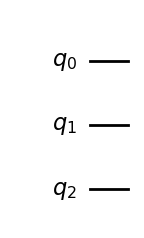

In [30]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
# qc.id(range(3))

qc.draw("mpl")

### Classical reference state

- Suppose you have a 3-qubit system and you want to start in the state $\ket{001}$ instead of the default state $\ket{000}$. This is an example of a purely classical reference state, and to construct it, you simply need to apply an X gate to qubit 0 (following Qiskit's qubit ordering), as $\ket{001} = X_{0} \ket{000}$ 

- In this case $U_{R}=I_{2} I_{1} X_{0} = I\otimes I \otimes X$ and $ket{\rho} = \ket{001}$



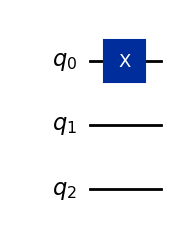

In [31]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.x(0)

qc.draw("mpl")

### Quantum reference state

- Quantum State that includes significant entanglement and superposition
- Suppose you aim to start with a more complex state that involves superposition and/or entanglement, such as $\ket{\rho}=\frac{1}{\sqrt{2}}(\ket{100}+\ket{111})$ 
- What operations should you do to create the target state $\ket{\rho}=\frac{1}{\sqrt{2}}(\ket{100}+\ket{111})$ from $\ket{000}$?
- What should be $U_{R}$?


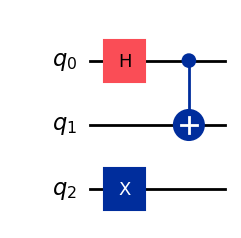

In [5]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

### Application Specific State

Quantum Machine Learning Specific

- In the context of a variational quantum classifier (VQC), the training data is encoded into a quantum state with a parameterized circuit known as a feature map
- where each parameter value represents a data point from the training dataset. 
- The ZZFeatureMap is a type of parameterized circuit that can be utilized to pass our data points (x) to this feature map.


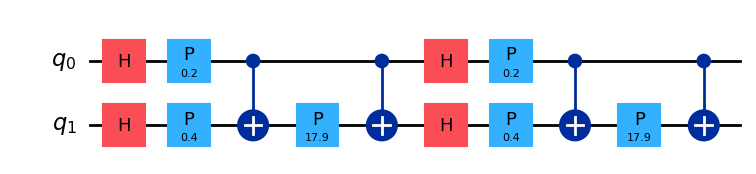

In [4]:
from qiskit.circuit.library import ZZFeatureMap

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.assign_parameters(data)
zz_feature_map_reference.decompose().draw("mpl")

### Ansatz Design
#### Parameterized Quantum Circuits

In parametrized quantum circuit (PQC), gates are defined with tunable parameters. It is possible to create this parametrized circuit without binding specific angles yet. So you can build the PQC first and then bind/assign the paramters. 

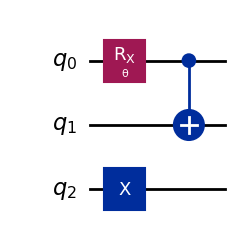

In [32]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

### Heuristic ansatze and trade-offs
#### N-local circuits

One of the most widely used examples of heuristic ansatzes is the N-local circuits, for a few reasons:


- Efficient implementation: composed of simple, local gates that can be implemented efficiently on a quantum computer, using a small number of physical qubits. 
- Captures important correlations: Can capture important correlations between the qubits in a quantum system, even with a small number of gates. This is because the local gates can act on neighboring qubits and create entanglement between them, which can be important for simulating complex quantum systems.

#### Structure of N-local circuits

- Each layer is formed by gates of size at most $N$, where $N$ has to be lower than the number of qubits.
- For a rotation layer,we use standard rotation operations, such as RX or CRZ gates.
- For an entanglement layer, we can use gates like Toffoli gates or CX with an entanglement strategy.


Let's create a quantum circuit that that is a

- 5 qubits N-local  
- Uses rotation blocks formed by RX or CRZ
- Uses entanglement blocks formed by Toffoli gates that act on qubits [0,1,2],[0,2,3],[4,2,1] and [3,1,0]
- 2 repetations (reps) each of these blocks

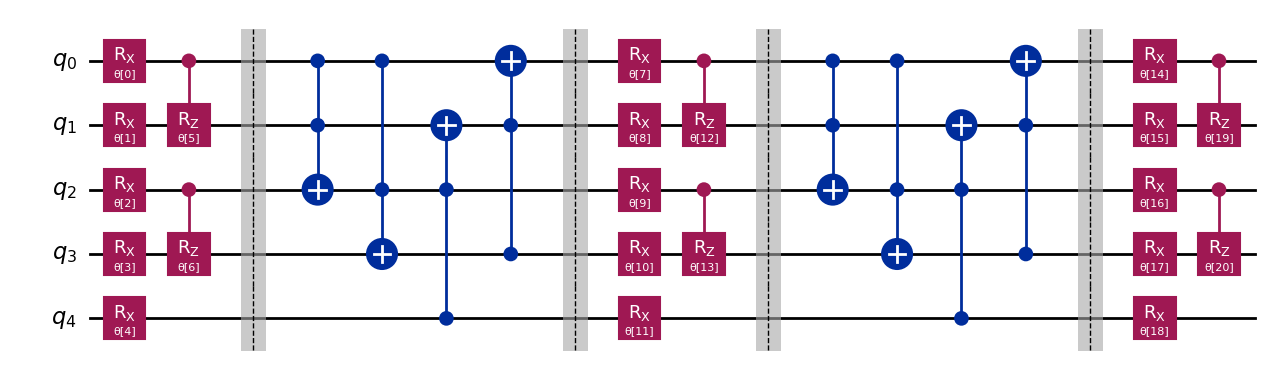

In [7]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

- What is the locality of the above circuit? 
- In most of the applications a 2 Local PQC is used.

Let's create a quantum circuit that that is a

- 5 qubits 2-local  
- Uses rotation blocks formed by RX or RZ
- Uses entanglement blocks formed by CNOT
- 2 repetations (reps) each of these blocks

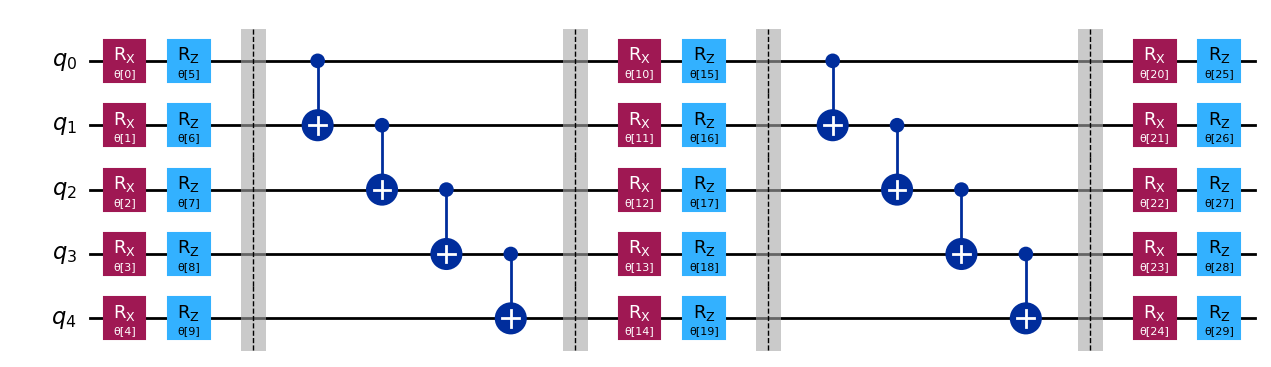

In [8]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

In this case, we used the linear entanglement distribution, where each qubit is entangled with the next. To learn about other strategies, refer to TwoLocal's [documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal).

### Cost function

In [11]:
# Defining the cost function


def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

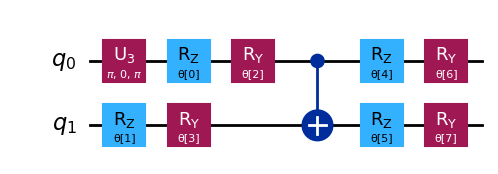

In [33]:
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
import numpy as np

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
#ansatz.assign_parameters(theta_list)
#print(ansatz.num_parameters)
ansatz.decompose().draw('mpl')

- We will first carry this out using a simulator: the StatevectorEstimator. 
- This is usually advisable for debugging before it's implimentation of the utility experimentation on real quantum hardware. 
- Increasingly, problems of interest are no longer classically simulable without state-of-the-art supercomputing facilities.

In [34]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[-1.389475]


In [17]:
Obs_matrix = observable.to_matrix()
eig_mat_obs = np.linalg.eigvals(Obs_matrix)

eig_mat_obs

array([ 4.+0.j, -4.+0.j,  2.+0.j, -2.+0.j])

### Optimization 

#### Local Optimizers 

- Start from an initial point and iteratively search for a minimum of the cost function by exploring nearby points. 
- Convergence is typically fast but highly sensitive on the initial point.
- Prone to getting stuck in local minima and may miss better solutions outside their current evaluation region.


In [15]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP")

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.999999996452395
       x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.558e-05 -1.207e+00
           -1.935e+00  4.079e-01 -4.079e-01]
     nit: 12
     jac: [-1.192e-07 -8.941e-08 -7.960e-04  2.544e-04  1.381e-03
            1.381e-03  5.430e-04  5.432e-04]
    nfev: 112
    njev: 12

### Application 1: Finding Minima for an Operator 

Find minimum eigenvalue of the operator $$\hat{O_{1}} = 2II - 2XX + 3YY− 3ZZ$$

### VQE Implementation

In [24]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np
import time as time

%time

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable=SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])


# Exact classical result
Matrix_obs = observable.to_matrix()

eig_mat_obs = np.linalg.eigvals(Matrix_obs)

eig_mat_obs

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 6.2 μs


array([ 4.+0.j, -6.+0.j,  6.+0.j,  4.+0.j])

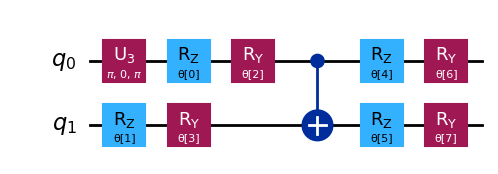

In [19]:

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [20]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [21]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [27]:
# SciPy minimizer routine
%time
from scipy.optimize import minimize
import time 

start_time = time.time()

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time
result

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 6.2 μs


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999993368835
       x: [ 1.719e+00  9.424e-01  1.571e+00  3.631e-05  1.917e+00
            1.225e+00  6.218e-01  6.218e-01]
    nfev: 123
   maxcv: 0.0

In [28]:

solution_eigenvalue = min(eig_mat_obs)

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 123
Time (s): 0.4680819511413574
Percent error: 1.11e-09


### Experiment to improve the speed and accuracy

- In the previous example we have not used any reference operator $U_{R}$
- Now let us think about how the ideal eigenstate $\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})$ can be obtained. Consider the following circuit.

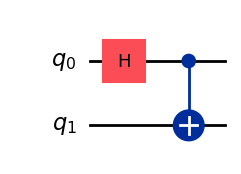

In [24]:
ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0, 1)

ideal_qc.draw("mpl")

We can quickly check that this circuit gives us the desired state.

In [26]:
from qiskit.quantum_info import Statevector

Statevector(ideal_qc)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


Now that we have seen how a circuit preparing the solution state looks like, it seems reasonable to use a Hadamard gate as a reference circuit, so that the full ansatz becomes:

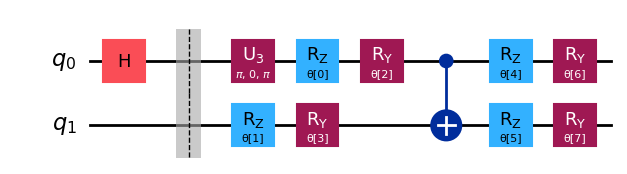

In [28]:
reference = QuantumCircuit(2)
reference.h(0)
# Include barrier to separate reference from variational form
reference.barrier()

ref_ansatz = ansatz.decompose().compose(reference, front=True)

ref_ansatz.draw("mpl")

- For this new circuit, the ideal solution could be reached with all the parameters set to 0
- This confirms that the choice of reference circuit is reasonable.
- Now let us compare the number of cost function evaluations, optimizer iterations and time taken with those of the previous attempt.

In [29]:
import time

start_time = time.time()

ref_result = minimize(cost_func_vqe, x0, args=(ref_ansatz, observable, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time


Using our optimial parameters to calculate the minimum eigenvalue:



In [30]:
experimental_min_eigenvalue_ref = cost_func_vqe(result.x, ansatz, observable, estimator)
print(experimental_min_eigenvalue_ref)

-5.999999993368835


In [32]:
print("ADDED REFERENCE STATE:")
print(f"""Number of iterations: {ref_result.nfev}""")
print(f"""Time (s): {execution_time}""")
print(
    f"Percent error: {abs((experimental_min_eigenvalue_ref - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

ADDED REFERENCE STATE:
Number of iterations: 197
Time (s): 0.5059211254119873
Percent error: 1.11e-09
